# Financial Data Analysis

## 1. Libraries, tuned settings and a Helper

In [615]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ggplot import ggplot, geom_line, aes
import graphlab as gl
import graphlab.aggregate as agg
from sklearn.cross_validation import train_test_split
from ggplot import *
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.cluster import KMeans


%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 4000

def box_plot(df,label):
    x = df[label]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                        gridspec_kw={"height_ratios": (.15, .85)})
    me = np.mean(x)
    st = x.std(); 
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist, kde=False)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xlim([me-2*st, me+2*st])
    plt.show()

## 2. Dataset

In [3]:
try:
    pnames = pd.read_csv("page_names.csv")
    pusage = pd.read_csv("page_usage.csv")
    print "page Names has {} samples with {} features each.".format(*pnames.shape)
    print "page usage has {} samples with {} features each.".format(*pusage.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

page Names has 741 samples with 2 features each.
page usage has 617256 samples with 4 features each.


### First Look

In [4]:
pnames.head()

,pageID,Name
0,page1,CostSavingsPhaseinSchedule?load
1,page2,BA MS Summary
2,page3,Production Cost Detail
3,page4,BVM SNLxl Template
4,page5,TV Market Overview


**Looks like Names represent categories as there can be more than 1 for a page ID.**

In [383]:
pnames.groupby('Name').agg('count').sort(columns='pageID', axis=0,ascending=False).head()

,pageID
Name,
Knowledge Base,5
Energy Contracts,3
Article,2
Power Plant Summary,2
Capacity & Generation Summary,2


**Null Check**

In [6]:
print(pnames.isnull().sum())
print(pusage.isnull().sum())

pageID    0
Name      0
dtype: int64
userID    0
pageID    0
day       0
time      0
dtype: int64


**Unique counts**

In [7]:
len(pusage['userID'].unique())

1138

In [8]:
pd.to_datetime(pusage['time'],format= '%H:%M:%S' ).dt.hour.unique()

array([13, 14, 15, 18, 19, 20, 21, 22, 23,  0, 16,  5, 12, 17,  1,  8,  9,
        2,  3,  4,  6,  7, 10, 11])

### Combine the two given datasets

In [9]:
pcomb = pd.merge(pusage,pnames,on='pageID')

**Number of views for each page**

In [10]:
pcomb['Name'].value_counts()

News                                                 61258
Editors' Picks                                       61012
News: Most Popular                                   61006
Features & Blogs                                     60944
Top News                                             60854
NewsWire                                             60394
My Market Indexes                                    36918
RRA Articles                                         36458
Issues In Focus                                      24022
Industry News                                        22378
Article                                              10430
Corporate Profile                                     8051
News Archive Page                                     4626
Financial Reports                                     4105
SNL Kagan Features                                    3550
Companies and Assets                                  3479
Power Plant Profile                                   34

#### Anomaly Detection for Pages:  

There is an entry in one of the top most views pages "New User Signup: Step 3". I am not sure if it has any meaning at all in this context. I would consider this as a part of noise. So would get rid of it.  
During my one the attempts at outlier detection, I also came across following pages, which I think can be removed too on the similar lines of reasoning:  
Login  
Password  
Settings Summary  
New User Signup: Step 4  
Redirector  
Excel View  
PDF View

In [384]:
pcomb_wo = pcomb.copy()
pcomb_wo = pcomb_wo[pcomb_wo['Name'] != 'New User Signup: Step 3']
pcomb_wo = pcomb_wo[~pcomb_wo['Name'].isin(['Login','Password','Settings Summary','New User Signup: Step 4','Redirector','Excel View','PDF View'])]

### Users Analysis

In [385]:
pcomb_wo.groupby(['userID','pageID','day']).agg('count').reset_index().sort(columns='time',ascending=False).rename(columns={"time":"count"}).drop(['Name'],axis=1).head()

,userID,pageID,day,count
28779,user550,page474,69,1500
3602,user1072,page726,84,675
3550,user1072,page519,84,675
3468,user1072,page182,84,675
3523,user1072,page429,84,675


#### Anamoly Detection for Users

1500 hits by one user for the same page in one day seems unconvincing for me. So I would remove it.

In [386]:
pcomb_wo = pcomb_wo[~((pcomb_wo['userID']=='user550') & (pcomb_wo['pageID']=='page474') & (pcomb_wo['day']==69))]

**Most active users**

In [418]:
pcomb_wo.groupby('userID').agg('count').sort(columns='pageID',ascending=False).head()

,pageID,day,time,Name
userID,,,,
user480,33826,33826,33826,33826
user1120,33059,33059,33059,33059
user1129,28141,28141,28141,28141
user115,10994,10994,10994,10994
user805,10733,10733,10733,10733


**Just 15 percent of the users consitute more than 80% of the total views**

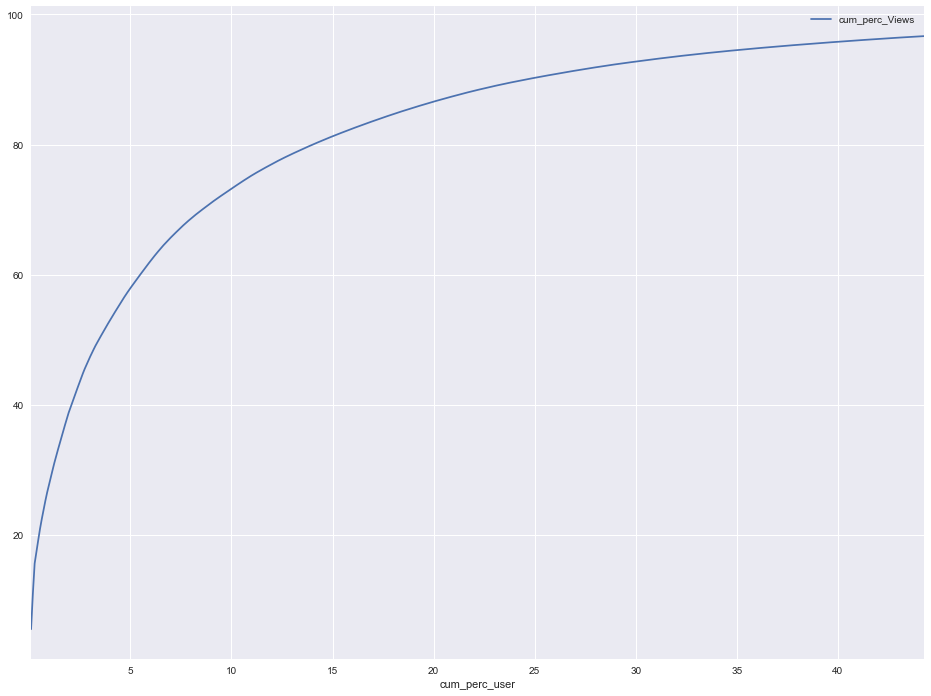

In [443]:
udf = pcomb_wo.groupby('userID').agg('count').sort(columns='pageID',ascending=False)
udf = udf.rename(columns={"pageID":"count"})
udf = udf.drop(['day','time'],axis=1)
udf['cum_perc_Views'] = (udf['count'].cumsum() / udf['count'].sum()) * 100
udf['cum_user_count']= udf.reset_index().sort(columns='cum_perc_Views')['userID'].cumsum().index + 1
udf['cum_perc_user'] = (udf['cum_user_count']/udf['cum_user_count'].tail(1)[0])*100 
udf = udf.drop('cum_user_count',axis=1)
udf.reset_index().sort(columns='cum_perc_Views').head(500).plot(x='cum_perc_user',y='cum_perc_Views',figsize=(16,12),kind='line')

** Analyzing the viewing habits of top two most active users **

In [684]:
mau = udf.reset_index().sort(columns='cum_perc_Views')
mau = mau[mau['cum_perc_user']<=15]
usdf = pcomb_wo[pcomb_wo['userID'].isin(mau.userID.values)]
temp = usdf.groupby(['userID','pageID']).agg('count').reset_index().rename(columns={"time":"count"}).drop(['Name','day'],axis=1)
x = temp[temp['userID']=='user480'].sort('count',ascending=False)
pd.merge(x,pcomb_wo,on=['pageID','userID']).Name.unique()

array(['Features & Blogs', 'News: Most Popular', "Editors' Picks", 'News',
       'Top News', 'Industry News', 'Issues In Focus', 'NewsWire',
       'Events: Company Meetings', 'Latest Filings',
       'Updated U.S. Bank Reg Financials', 'Events: Earnings Releases',
       'Events: Conference Calls', 'Updated Company Financials',
       'Companies and Assets', 'Corporate Profile', 'Article',
       'Exchange Rates', 'Economic Data', 'Geographies', 'Officers',
       'Universal Search Results', 'Officers Bio', 'Departments',
       'Community Banker: Loans and Assets', 'Peer Analytics Report',
       'Document Detail', 'Financial Reports', 'Credit Ratings',
       'Corporate Structure', 'M&A History', 'Corporate Compensation',
       'Global Bank Branch Map',
       'Community Banker: Deposits and Other Liabilities',
       'Demographics Data', 'MyInteractive - Features',
       'BVM Launch Application', 'Community Banker: Asset Quality',
       'Currency Exchange Rates', 'Press Release

In [685]:
usdf = pcomb_wo[pcomb_wo['userID'].isin(mau.userID.values)]
temp = usdf[usdf['userID']!='user480'].groupby(['userID','pageID']).agg('count').reset_index().rename(columns={"time":"count"}).drop(['Name','day'],axis=1).sort('count',ascending=False)
x = temp[temp['userID']=='user1120'].sort('count',ascending=False)
pd.merge(x,pcomb_wo,on=['pageID','userID']).Name.unique()

array(['NewsWire', 'News', 'My Market Indexes', 'News: Most Popular',
       "Editors' Picks", 'Top News', 'Features & Blogs', 'RRA Articles',
       'Article', 'Knowledge Base', 'Document Detail', 'File',
       'Departments', 'Select Services', 'Wizard - EmailAlerts',
       'NewsWire Popup'], dtype=object)

### Pages Analysis

In [686]:
pageViews = pcomb_wo['Name'].value_counts()
d = {'Name':pageViews.index,'Views':pageViews.values}
pageViews = pd.DataFrame(data=d)
pageViews['cum_perc_Views'] = (pageViews['Views'].cumsum() / pageViews['Views'].sum()) * 100
pageViews.head(55)

,Name,Views,cum_perc_Views
0,News,61258,10.102546
1,Editors' Picks,61012,20.164522
2,News: Most Popular,61006,30.225509
3,Features & Blogs,60944,40.276271
4,Top News,60854,50.312190
5,NewsWire,60394,60.272247
6,My Market Indexes,36918,66.360689
7,RRA Articles,36458,72.373269
8,Issues In Focus,24022,76.334929
9,Industry News,22378,80.025463


**Out of a total of 720 distinct page categories, top 35 most viewed constitute more than 90% of all the views**

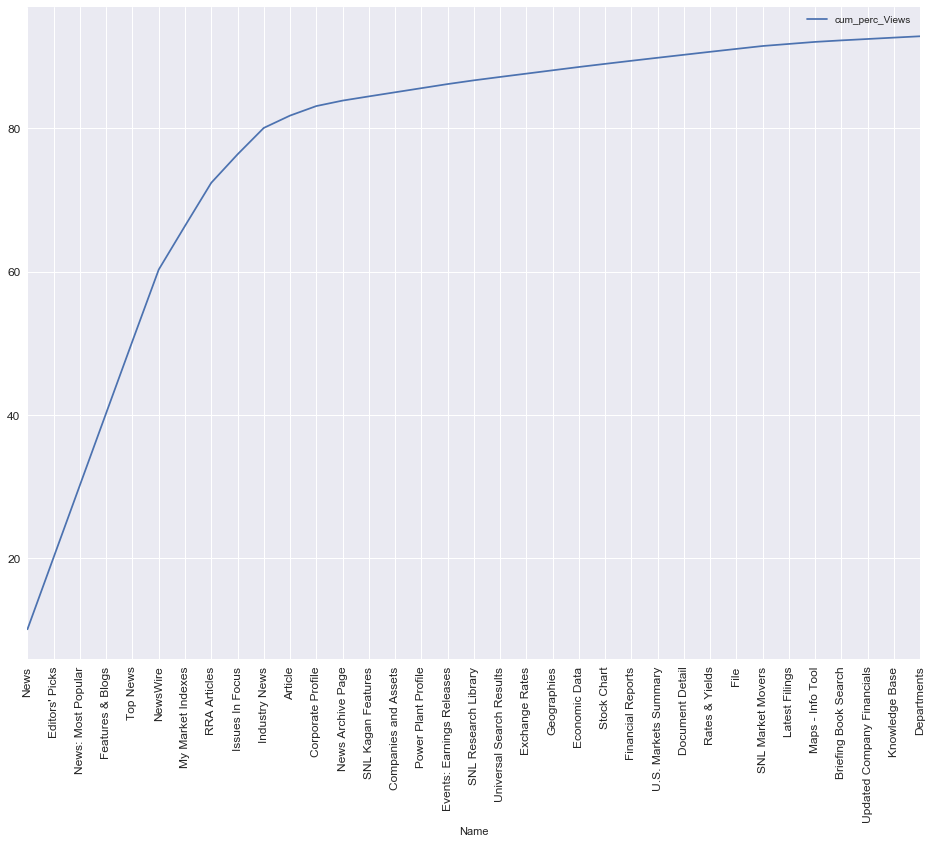

In [394]:
xticks = [x for x in range(35)]
pageViews.head(35).plot(x='Name',y='cum_perc_Views',kind='line',figsize=(16,12),xticks = xticks,rot=90,fontsize=12)

### Breakdown of top 35 most viewed pages:

A cursory inspection tells us that the pages can be categorized into one of the following: 

**News**  

This may include all the pages related to news, opinions, blogs, articles, specifically:  
News  
Editors' Picks  
News: Most Popular  
Features & Blogs  
Top News  
NewsWire  
RRA Articles  
Issues In Focus  
Industry News  
Article  
Events: Earnings Releases  
News Archive Page  
Latest Filings  
US Markets Summary  
SNL Market Movers  

**Individual Portfolio**  

This can include all the pages related to an end user's personalized experience on the platform, specifically:  
My Market Indexes  
Corporate Profile  
Stock Chart  
Document Detail  
Power Plant Profile  

**Research**  

This can include all the pages related to search performed, any specific research done, specifically:  
Universal Search Results  
SNL Research Library  
Briefing Book Search  
Knowledge Base  

**Others**  

This can include the rest of the pages, specifically:  
Financial Reports  
SNL Kagan Features  
Companies and Assets  
Exchange Rates  
Geographies  
Economic Data  
Rates & Yields  
File  
Maps - Info Tool  
Departments  
Updated Company Financials

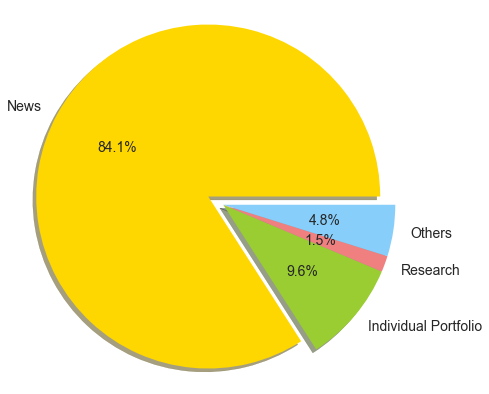

In [396]:
nv = pageViews.loc[pageViews['Name'].isin(['News','Editors\' Picks','News: Most Popular','Features & Blogs',
                                     'Top News','NewsWire','RRA Articles','Issues In Focus','Industry News','Article',
                                     'Events: Earnings Releases','News Archive Page','Latest Filings'
                                      ,'US Markets Summary','SNL Market Movers']),'Views'].sum(axis=0)
ipv = pageViews.loc[pageViews['Name'].isin(['My Market Indexes','Corporate Profile','Stock Chart','Document Detail',
                                            'Power Plant Profile']),'Views'].sum(axis=0)
rv = pageViews.loc[pageViews['Name'].isin(['Universal Search Results','SNL Research Library','Briefing Book Search'
                                          ,'Knowledge Base']),'Views'].sum(axis=0)
ov = pageViews.loc[pageViews['Name'].isin(['Financial Reports','SNL Kagan Features','Companies and Assets'
                                          ,'Exchange Rates','Geographies','Economic Data','Rates & Yields',
                                          'File','Maps - Info Tool','Departments','Updated Company Financials'
                                          ]),'Views'].sum(axis=0)  

# Data to plot

labels = ['News','Individual Portfolio','Research','Others']
Views = [nv, ipv, rv, ov]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
mpl.rcParams['font.size'] = 14.0

patches, texts, autotexts  = plt.pie(Views, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
texts[0].set_fontsize(14)
texts[1].set_fontsize(14)
texts[2].set_fontsize(14)
texts[3].set_fontsize(14)

plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(7,7) 
plt.show()

**More than 500 page categories contribute to less than 1 percent of views**

In [397]:
pageViews[pageViews.cum_perc_Views > 99].shape

(509, 3)

### Most viewed pages viewership based on time of the day

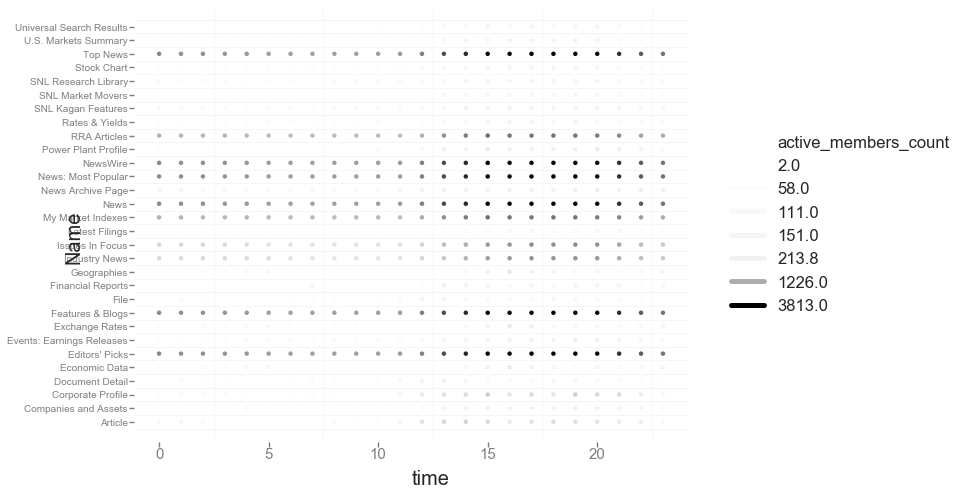

<ggplot: (330425213)>

In [403]:
mvp = pageViews['Name'].head(30)
uvdf = pd.DataFrame(pcomb_wo.loc[pcomb_wo['Name'].isin(mvp.values),['userID','time','Name']])
uvdf = uvdf.loc[uvdf['userID'].isin(mau),:]
uvdf['time'] = pd.to_datetime(uvdf['time'],format= '%H:%M:%S' ).dt.hour
uvdfN = uvdf.groupby(['Name','time']).agg('count').reset_index()
uvdfN = uvdfN.rename(columns={"userID":"active_members_count"})

p = ggplot(aes(x='time', y='Name', color='active_members_count'), data=uvdfN) + \
    geom_point() + \
    scale_color_gradient(low = 'white', high = 'black')   

t = theme_bw()
#t._rcParams['figure.figsize'] = 20,20 # Legend font size
t._rcParams['font.size'] = 20 # Legend font size
t._rcParams['xtick.labelsize'] = 15 # xaxis tick label size
t._rcParams['ytick.labelsize'] = 10 # yaxis tick label size
t._rcParams['axes.labelsize'] = 15  # axis label size
p + t    

In [404]:
del uvdf

### Most of the views happen in PM

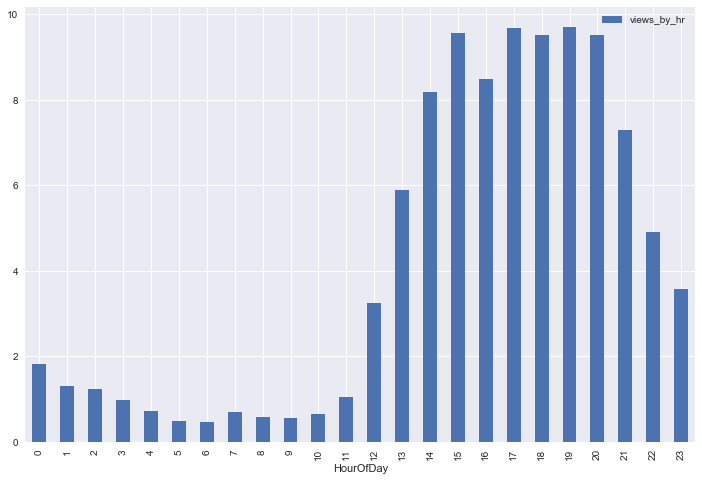

In [339]:
p = pd.to_datetime(pcomb_wo['time'],format= '%H:%M:%S' ).dt.hour
tsViews = p.value_counts()
d = {'HourOfDay':tsViews.index,'Views':tsViews.values}
tsViews = pd.DataFrame(data=d)
tsViews['views_by_hr'] = (tsViews.sort_values('HourOfDay')['Views']/tsViews['Views'].sum())*100
tsViews.sort_values('HourOfDay',axis=0).plot(x='HourOfDay',y='views_by_hr',kind='bar',figsize=(12,8))

### Views by day

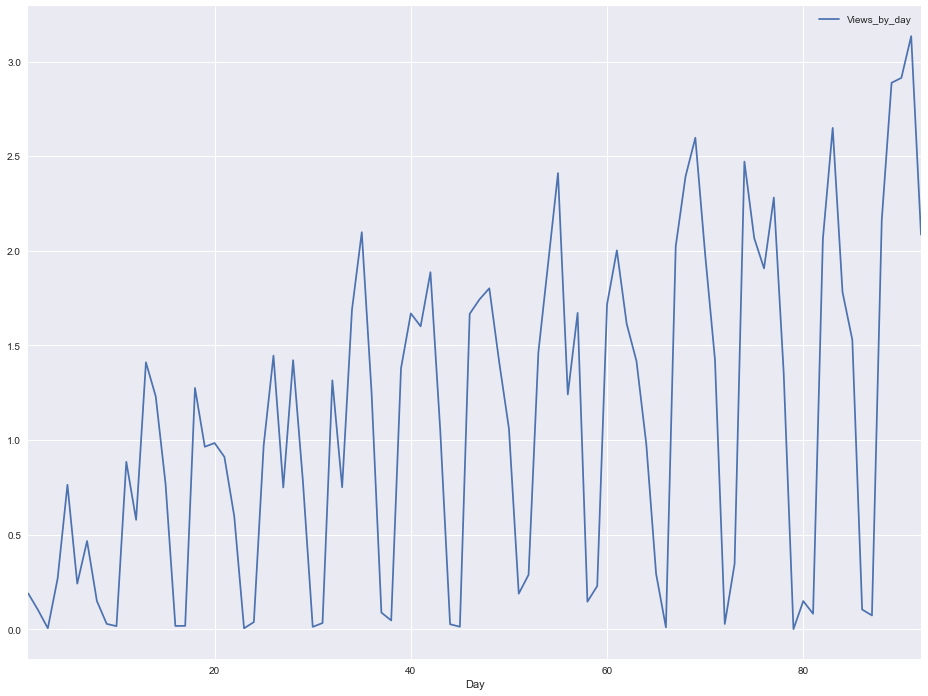

In [341]:
ViewsByDay = pcomb_wo['day'].value_counts()
d = {'Day':ViewsByDay.index,'Views':ViewsByDay.values}
ViewsByDay = pd.DataFrame(data=d)
ViewsByDay['Views_by_day'] = (ViewsByDay.sort_values('Day')['Views'] / ViewsByDay['Views'].sum()) * 100
ViewsByDay.sort_values('Day').plot(x='Day',y='Views_by_day',kind='line',figsize=(16,12))

The trend here is as expected. The peaks may be pointing to the middle of the week while the valleys pointing to week ends.  
Also there is an increasing trend visible, with a "bump" showing up every 3 weeks or so, starting the 2nd week. 

**News page individual analysis**

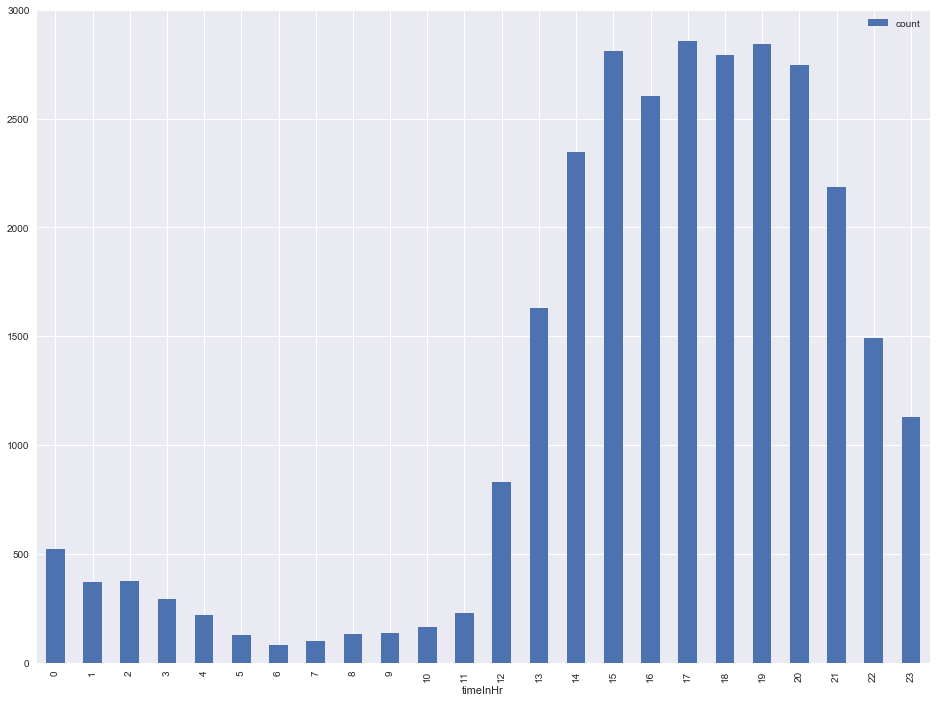

In [344]:
temp = pcomb_wo.copy()
temp['timeInHr']= pd.to_datetime(temp['time'],format='%H:%M:%S').dt.hour.astype(int)
temp = temp.drop('time',axis=1)
tempgr = temp.groupby(['Name','timeInHr']).agg('count')
s = tempgr.loc['News','userID'].sort_values(ascending=False)
d = {'count':s.values, 'timeInHr':s.index}
NewsStats = pd.DataFrame(data=d)
NewsStats.sort(columns='timeInHr').plot(x='timeInHr',y='count',kind='bar',figsize=(16,12))

**Exchange Rate page individual analysis**

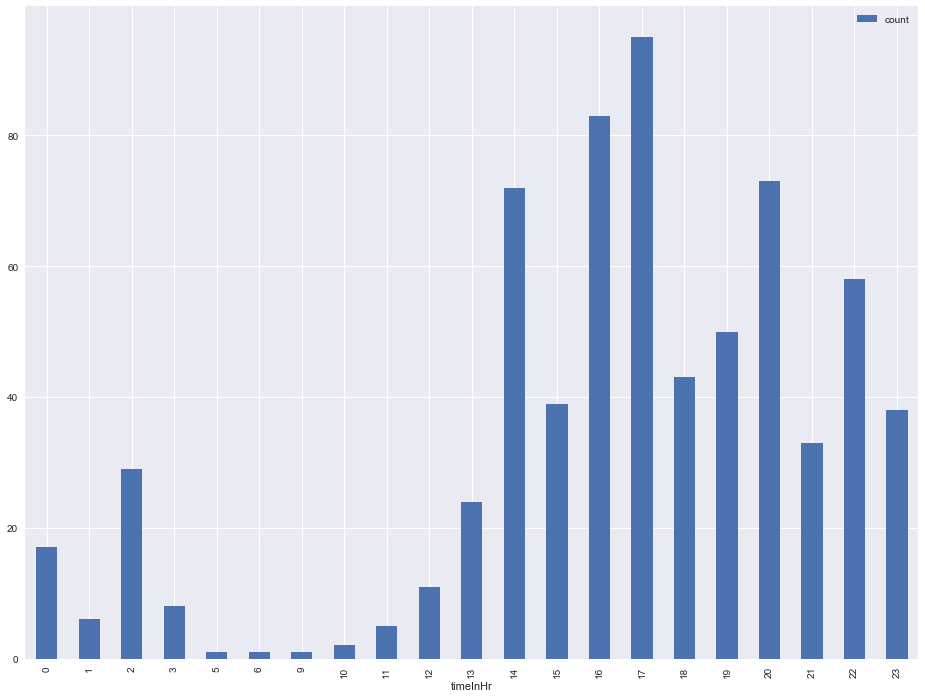

In [687]:
s = tempgr.loc['Exchange Rates','userID'].sort_values(ascending=False)
d = {'count':s.values, 'timeInHr':s.index}
ERStats = pd.DataFrame(data=d)
ERStats.sort(columns='timeInHr').plot(x='timeInHr',y='count',kind='bar',figsize=(16,12))

### Finding most similar page to page 595 

**Manual approach**

I performed a visual analysis to find the most similar page to a given page.  
This returned a simple popularity based model.  
That is all the of the matches found were nothing but the most viewed in the entire dataset.   
Following is what this analysis yielded for **page 595**  
Page 710  
Page 75  
Page 49  
Page 308  
Page 650  
Page 638  
Page 133  
Page 544  

Looking at their names, these turn out to be following :  
News  
NewsWire  
Top News  
News: Most Popular  
Features & Blogs  
Editors' Picks  
RRA Articles  
My Market Indexes
  
As expected, all were equal in similarity  to Physical Survey 

In [298]:
pcomb.loc[pcomb['pageID'].isin(['page710','page75','page49','page308','page650','page638','page133','page544']),'Name'].unique()

array(['News', 'NewsWire', 'Top News', 'News: Most Popular',
       'Features & Blogs', "Editors' Picks", 'RRA Articles',
       'My Market Indexes'], dtype=object)

**Change of approach: Using Graphlab**

Using Graphlab's unified interface for training recommender models that chooses the Item Similarity method (that ranks an item according to its similarity to other items observed for the user in question), following are the most similar pages found to page595 (Physical Survey) and in that order:  
page505 : OTC Survey  
page605 : Forward Coal  
page597 : Energy Markets Coal Summary  
page696 : SNL Coal Forecast: Price   
page65  : MISO Capacity Markets


In [688]:
sf = gl.SFrame(pcomb_wo)
model = gl.recommender.create(sf, user_id='userID', item_id='pageID',ranking=False)

Recsys training: model = item_similarity

Warning: Ignoring columns day, time, Name;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 606362 observations with 1130 users and 733 items.

Data prepared in: 0.453789s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 49.397ms                       | 88.25      |

| 51.294ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 57.052ms                            | 0                | 0               |

| 82ms                                | 100              | 733             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.132138s

**Pages found**

In [689]:
model.get_similar_items(['page595'],k=5)

pageID,similar,score,rank
page595,page505,0.625,1
page595,page605,0.444444417953,2
page595,page597,0.300000011921,3
page595,page696,0.25,4
page595,page65,0.199999988079,5


**Understanding the similarity**

In [690]:
it1 = pcomb_wo.loc[(pcomb_wo['pageID'] == 'page595'),'userID'].unique()
it2 = pcomb_wo.loc[(pcomb_wo['pageID'] == 'page505'),'userID'].unique()
print(np.intersect1d(it1,it2))
it2 = pcomb_wo.loc[(pcomb_wo['pageID'] == 'page605'),'userID'].unique()
print(np.intersect1d(it1,it2))
it2 = pcomb_wo.loc[(pcomb_wo['pageID'] == 'page597'),'userID'].unique()
print(np.intersect1d(it1,it2))

['user341' 'user41' 'user428' 'user679' 'user699']
['user341' 'user41' 'user679' 'user820']
['user341' 'user41' 'user428' 'user679' 'user699' 'user820']


In [527]:
print pcomb_wo.loc[(pcomb_wo['pageID']=='page595'),['userID','day']].groupby('userID').agg('count').reset_index().sort(columns='userID')
print pcomb_wo.loc[(pcomb_wo['pageID']=='page505'),['userID','day']].groupby('userID').agg('count').reset_index().sort(columns='userID') #23
print pcomb_wo.loc[(pcomb_wo['pageID']=='page605'),['userID','day']].groupby('userID').agg('count').reset_index().sort(columns='userID') #19
print pcomb_wo.loc[(pcomb_wo['pageID']=='page696'),['userID','day']].groupby('userID').agg('count').reset_index().sort(columns='userID') #19
print pcomb_wo.loc[(pcomb_wo['pageID']=='page65'),['userID','day']].groupby('userID').agg('count').reset_index().sort(columns='userID') #19

    userID  day
0  user341   23
1   user41    1
2  user428    2
3  user679    5
4  user699   10
5  user820    3
     userID  day
0  user1121    1
1   user341    8
2    user41    8
3   user428    2
4   user634    1
5   user679    4
6   user699    1
    userID  day
0  user341    7
1   user41    1
2  user634    1
3  user679    4
4  user727    3
5  user820    1
6  user976    1
    userID  day
0   user41    1
1  user712    1
2  user727    2
3  user820    6
     userID  day
0  user1004    9
1   user129    3
2   user186    3
3   user428    1
4   user820    2
5   user856   10


In [501]:
pcomb_wo.loc[pcomb_wo['pageID'].isin(['page505','page605','page597','page696','page65']),['pageID','Name']].drop_duplicates('Name')

,pageID,Name
608445,page597,Energy Markets Coal Summary
613145,page65,MISO Capacity Markets
615445,page505,OTC Survey
615474,page605,Forward Coal
615929,page696,SNL Coal Forecast: Price


### To obtain users  similar to user482

In [502]:
model = gl.recommender.create(trainsf, user_id='pageID', item_id='userID',ranking=False)

Recsys training: model = item_similarity

Warning: Ignoring columns day, time, Name;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 550424 observations with 730 users and 1130 items.

Data prepared in: 0.416049s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.174ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.775ms                             | 11.5             | 132             |

| 75.647ms                            | 100              | 1130            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.11537s

In [503]:
model.get_similar_items(['user482'],k=5)

userID,similar,score,rank
user482,user1103,0.692307710648,1
user482,user716,0.642857134342,2
user482,user898,0.642857134342,3
user482,user231,0.615384638309,4
user482,user37,0.615384638309,5


**Understanding similarity**

In [530]:
it1 = pcomb_wo.loc[(pcomb_wo['userID'] == 'user482'),'pageID'].unique()
it2 = pcomb_wo.loc[(pcomb_wo['userID'] == 'user1103'),'pageID'].unique()
print len(np.intersect1d(it1,it2))
it2 = pcomb_wo.loc[(pcomb_wo['userID'] == 'user716'),'pageID'].unique()
print len(np.intersect1d(it1,it2))
com = np.intersect1d(it1,it2)
it2 = pcomb_wo.loc[(pcomb_wo['userID'] == 'user898'),'pageID'].unique()
com2 = np.intersect1d(it1,it2)
print len(com2)
it2 = pcomb_wo.loc[(pcomb_wo['userID'] == 'user231'),'pageID'].unique()
com2 = np.intersect1d(it1,it2)
print len(com2)
it2 = pcomb_wo.loc[(pcomb_wo['userID'] == 'user37'),'pageID'].unique()    
com2 = np.intersect1d(it1,it2)
print len(com2)

10
10
10
9
9


## End of Project

**********************************************************

**Rough Section. Can be ignored**

In [683]:
#pusage_dt = pusage.copy()
#pusage_dt['timeTS'] = pd.to_datetime(pusage['time'],format= '%H:%M:%S' ).dt.time
#pusage_dt = pusage_dt.drop('time',axis=1)
#mo = pcomb_wo.groupby(['userID','pageID','day']).agg('count').reset_index().sort(columns='time',ascending=False).rename(columns={"time":"count"}).drop(['Name'],axis=1)
#common = pd.merge(pcomb_wo,upo,on=['pageID','userID','day'])
#df1.loc[~df1.set_index(list(df1.columns)).index.isin(df2.set_index(list(df2.columns)).index)]
#pcomb_wo = pcomb_wo.loc[~pcomb_wo.set_index(list(pcomb_wo.columns)).index.isin(common.set_index(list(common.columns)).index)]
#pcomb_wo[pcomb_wo['pageID']=='page135'] #Weekly U. S. Coal Production By Region
#pcomb_wo[pcomb_wo['pageID']=='page65'] #MISO Capacity Markets
#usdfN = usdf.groupby(['day','userID']).agg('count').reset_index().sort(columns='time',ascending=False).rename(columns={"time":"count"}).drop(['Name','pageID'],axis=1)
#usdfN = usdfN.sort(columns='day')
#usdfN.head()
#.reset_index().sort(columns='time',ascending=False).rename(columns={"time":"count"}).drop(['Name'],axis=1)

#onehot = pd.get_dummies(temp['userID'])
#temp = temp.drop(['userID'],axis=1)
#temp = temp.join(onehot)
#onehot = pd.get_dummies(temp['pageID'])
#temp = temp.drop(['pageID'],axis=1)
#temp = temp.join(onehot)
#pca = PCA(n_components=2)
#pca.fit(temp)
#redtemp = pca.transform(temp)
#redtemp = pd.DataFrame(redtemp,columns=['Dimension 1', 'Dimension 2']) 
#pca.explained_variance_ratio_
#clusterer = GMM(n_components=2)
#clusterer.fit(redtemp)
#preds = clusterer.predict(redtemp)
#centers = clusterer.means_
#true_centers = pca.inverse_transform(centers)
#true_centers = pd.DataFrame(np.round(true_centers), columns = temp.keys())
#true_centers.index = segments
#model = gl.kmeans.create(tsf, num_clusters=3)
#clusterer = GMM(n_components=3)
#clusterer.fit(temp)
#preds = clusterer.predict(temp)
#centers = clusterer.means_
#kclusterer = KMeans(n_clusters=3)
#preds = kclusterer.fit_predict(temp)
#centers = kclusterer.cluster_centers_
#centers
#print pcomb_wo.loc[pcomb_wo['pageID']=='page322','Name'].unique()
#print pcomb_wo.loc[pcomb_wo['pageID']=='page95','Name'].unique()
#print pcomb_wo.loc[pcomb_wo['pageID']=='page499','Name'].unique()

#
#uvdf = uvdf.loc[uvdf['userID'].isin(mau),:]
#uvdf['time'] = pd.to_datetime(uvdf['time'],format= '%H:%M:%S' ).dt.hour
#uvdfN = uvdf.groupby(['Name','time']).agg('count').reset_index()
#uvdfN = uvdfN.rename(columns={"userID":"active_members_count"})
#uvdfN.head()
#p = ggplot(aes(x='time', y='Name', color='active_members_count'), data=uvdfN) + \
#    geom_point() + \
#    scale_color_gradient(low = 'white', high = 'black')   

#t = theme_bw()
#t._rcParams['figure.figsize'] = 20,20 # Legend font size
#t._rcParams['font.size'] = 20 # Legend font size
#t._rcParams['xtick.labelsize'] = 15 # xaxis tick label size
#t._rcParams['ytick.labelsize'] = 10 # yaxis tick label size
#t._rcParams['axes.labelsize'] = 15  # axis label size
#p + t    

#df_time = pcomb_wo.copy()
#df_time['timeInHr'] = pd.to_datetime(pusage['time'],format= '%H:%M:%S' ).dt.hour
#df_time = df_time.drop('time',axis=1)
#sf_time = gl.SFrame(df_time.head(100))
#m = gl.toolkits.anomaly_detection.create(sf_time,verbose=False)
#m['scores']

#ple = preprocessing.LabelEncoder()
#ple.fit(list(temp['pageID'].values))
#temp['pageID'] = ple.transform(list(temp['pageID'].values))
#ule = preprocessing.LabelEncoder()
#ule.fit(list(temp['userID'].values))
#temp['userID'] = ule.transform(list(temp['userID'].values))
#print temp.shape